# Transient association

Extending the model in association.ipynb to the case of time-varying weights.

In [39]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import cmdstanpy

In [40]:
# for nice plots when shown on GitHub nb viewer
import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')

## Simple mixture with time-dependent weight

Consider observations drawn from a mixture of 2 gaussian distributions with different means and the same standard deviation. Each population has an associated weight, $w$, the set of which forms a 2-simplex. The weight of one component varies in time such that

$$
w_0(t) \propto t, w_1(t) = 1 - w_0(t)
$$

The model can be parameterised with a latent categorical variable or *label*, $\lambda$: 

$$
\lambda \sim Categorical(w) 
$$

The observation $y_n$ is distributed according to which mixture componenet it is generated from.

$$
y_k \sim Normal(\mu_k, \sigma^2)   
$$
    
In order to treat this model in Stan, we marginalise over the discrete parameter:

$$
p(y \ | \ t, \ w, \mu, \sigma) = \sum_{k = 1}^2 w_k(t) Normal( y \ | \ \mu_k, \sigma^2)
$$
    
  

In [43]:
# compile the stan simulation
simu_file = 'stan/transient_mixture_sim.stan'
simulation = cmdstanpy.CmdStanModel(stan_file=simu_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/association/stan/transient_mixture_sim
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/association/stan/transient_mixture_sim


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


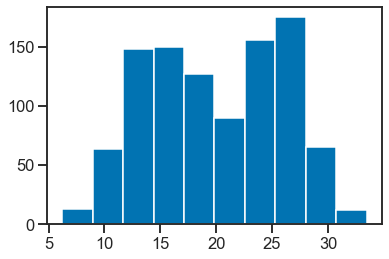

In [95]:
# Use stan to simulate draws from this mixutre model
t = np.linspace(0.01, 1, 1000)
simu_parameters = {'mu' : [15, 25],
                   'sigma' : 3, 
                   't' : t, 
                   'N_obs' : len(t)}

simu = simulation.sample(data=simu_parameters, fixed_param=True, 
                         iter_sampling=1, chains=1, seed=42)

# plot the simulation
y_simu = simu.stan_variable("y").values[0]
plt.hist(y_simu);
ax.set_xlabel("y");

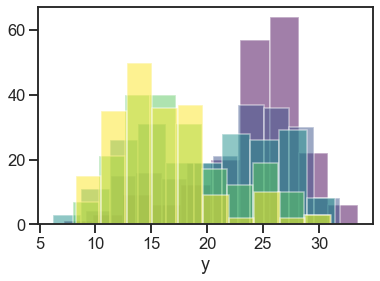

In [115]:
colors = plt.cm.viridis(np.linspace(0, 1, 5))
fig, ax = plt.subplots()
for a, b, c in zip([0, 200, 400, 600, 800], [200, 400, 600, 800, -1], colors):
    ax.hist(y_simu[a:b], alpha=0.5, color=c)
    ax.set_xlabel("y")

In [97]:
# compile the stan model
model_file = 'stan/transient_mixture.stan'
model = cmdstanpy.CmdStanModel(stan_file=model_file)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/fran/projects/association/stan/transient_mixture


In [98]:
# fit the stan model
data = {'N_obs' : len(y_simu), 'y' : y_simu, 't': t}

fit = model.sample(data=data, iter_sampling=1000, chains=4, seed=42)
#print(fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


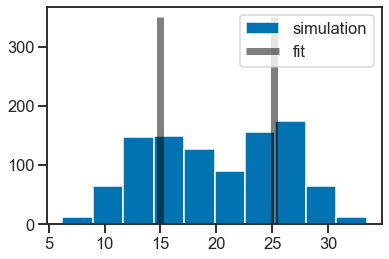

In [99]:
# plot the fit mu onto the simulated data
mu = fit.stan_variable("mu").values
plt.hist(y_simu, label = 'simulation');
plt.vlines([np.mean(mu.T[0]), np.mean(mu.T[1])], 0, 350, 
           linewidth = 7, alpha = 0.5, label = 'fit', color='k')
plt.legend()

## Explicit modelling of the association

In more physical applications, we want to know the rigorous probability for the association of an observation $y_i$ with a population component $k$. In order to do this, we basically want the marginal posterior for $\lambda$.

There are two things we can do in Stan to provide some useful information on this probability. 

* Save the values of the log probability `lp[i, k]` which correspsonds to $p(\lambda, y | \mu, \sigma)$. These can be marginalised to give $p(\lambda | \mu, \sigma, y)$
* Generate discrete samples based on `lp[i, k]` using a categorical RNG.

In [100]:
# compile a new model for the problem
explicit_model_file = 'stan/transient_mixture_explicit.stan'
explicit_model = cmdstanpy.CmdStanModel(stan_file=explicit_model_file)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/fran/projects/association/stan/transient_mixture_explicit


In [101]:
# fit this model
explicit_fit = explicit_model.sample(data=data, iter_sampling=1000, 
                                     chains=4, seed=42)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


### Probability that observation $i$ comes from component $k$

For each observation $y_i$, the value of the log probability `lp[i, k]` is the log of $p(\lambda = k, y_i | \mu, \sigma)$. Averaging over the posterior draws gives $q(\lambda = k | y_i, \mu, \sigma)$, which can be normalised to give the final result:

$$
p(\lambda = k | y_i, \mu, \sigma) = \frac{q(\lambda = k | y_i, \mu, \sigma)}{\sum_l q(\lambda = l | y_i, \mu, \sigma)}
$$

In [102]:
logprob = explicit_fit.stan_variable("lp").values
logprob = logprob.reshape(4000, 2, len(y_simu))
logprob = logprob.transpose(2, 1, 0)
np.shape(logprob)

(1000, 2, 4000)

Text(0.5, 0, 'y')

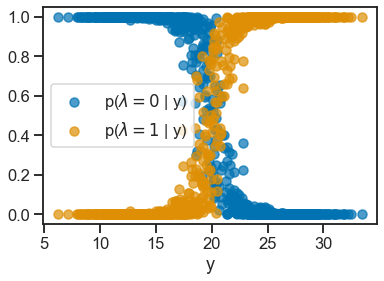

In [116]:
# answer: what is the probability that observation i comes from component k?

# find normalised marginal probability 
# associated with each observation
lp_l0 = []
lp_l1 = []
prob_l0 = []
prob_l1 = []
for i in range(len(y_simu)):
    # extract all iterations for all chains
    lp_i_l0 = logprob[i][0]
    lp_i_l1 = logprob[i][1]
    # exponentiate and average
    lp_l0.append(np.mean(np.exp(lp_i_l0)))
    lp_l1.append(np.mean(np.exp(lp_i_l1)))
    # normalise
    norm = (lp_l0[i] + lp_l1[i])
    prob_l0.append(lp_l0[i] / norm)
    prob_l1.append(lp_l1[i] / norm)

# plot the probabilities for different values of y_i
plt.scatter(y_simu, prob_l0, alpha = 0.7, label = 'p($\lambda = 0$ | y)')
plt.scatter(y_simu, prob_l1, alpha = 0.7, label = 'p($\lambda = 1$ | y)')
plt.legend()
plt.xlabel("y")

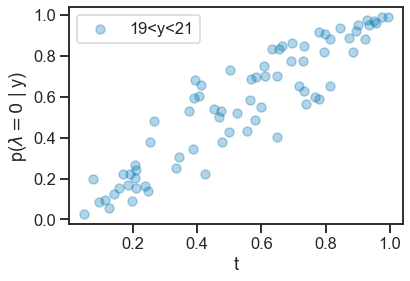

In [123]:
fig, ax = plt.subplots()
mask = (y_simu > 19) & (y_simu < 21)
ax.scatter(t[mask], np.array(prob_l0)[mask], alpha=0.3, label="19<y<21")
#ax.scatter(t[~mask], np.array(prob_l0)[~mask], alpha=0.3, label="y>20")
ax.set_xlabel("t")
ax.set_ylabel("p($\lambda = 0$ | y)")
ax.legend()